# Image Classification dengan MobileNet

##Business Understanding
- Aplikasi AI untuk Keselamatan: Model ini dikembangkan sebagai inti dari sistem klasifikasi gambar bencana atau insiden darurat. Tujuannya adalah menyediakan analisis visual otomatis dan cepat.

- Akselerasi Respon Darurat: Dengan identifikasi visual otomatis, sistem dapat mempercepat evakuasi yang relevan.

- Optimalkan dan Skalakan: Penggunaan MobileNet memungkinkan integrasi pada perangkat mobile dengan sumber daya terbatas, sehingga menjamin aksesibilitas dan kecepatan inferensi yang tinggi di lapangan.

## Data Understanding
- Data Gambar Bencana: Dataset AIDERdata dari Kaggle berisi gambar-gambar yang dikategorikan berdasarkan jenis bencana/insiden.

- Sumber Data: Data merupakan kumpulan gambar yang mungkin dikumpulkan dari berbagai skenario bencana, dengan fokus pada visual untuk pelatihan model pembelajaran mesin.

- Data Multikelas: Tugas klasifikasi bersifat multi-kelas (misalnya: kebakaran, banjir, kerusakan bangunan). Distribusi kelas perlu seimbang agar model tidak bias.

- Realistis & Bervariasi: Gambar-gambar diharapkan memiliki variasi dalam kondisi pencahayaan, sudut pengambilan, dan latar belakang, yang penting untuk melatih model yang robust.



##  Setup & Install Dependencies

In [ ]:
!pip install -q tensorflowjs kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import tensorflowjs as tfjs

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


TensorFlow version: 2.19.0
GPU available: []


##  Setup Kaggle API & Download Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clguo1/aiderdata")

print("Path to dataset files:", path)

100%|██████████| 263M/263M [00:02<00:00, 114MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/clguo1/aiderdata/versions/1


In [ ]:
import shutil
import os

def move_dataset(source_path, target_dir="/content"):
    # Membuat direktori tujuan jika belum ada
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Direktori {target_dir} berhasil dibuat.")

    # List semua file/folder di path sumber
    files = os.listdir(source_path)

    for f in files:
        src = os.path.join(source_path, f)
        dst = os.path.join(target_dir, f)

        # Memindahkan file atau folder
        if os.path.exists(dst):
            print(f"Skipping: {f} sudah ada di tujuan.")
        else:
            shutil.move(src, dst)
            print(f"Moved: {f}")

# Eksekusi fungsi menggunakan variabel 'path' dari output kagglehub Anda
move_dataset(path)

Moved: AIDER


## Konfigurasi & Hyperparameters

In [ ]:
# Sesuaikan path ini dengan struktur dataset Anda
# Jika dataset punya subfolder berbeda, ubah path ini
DATA_DIR = 'AIDER'  # Ubah sesuai struktur dataset

# Hyperparameters
IMG_SIZE = (224, 224)  # MobileNet input size
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Early stopping threshold
ACCURACY_THRESHOLD = 0.97

# Random seed untuk reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data Preparation & Augmentation

In [ ]:
# Data Augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15  # 15% untuk validation
)

# Hanya rescaling untuk validation dan test
test_datagen = ImageDataGenerator(
    rescale=1./255
)

print(" Data generators created with augmentation!")

✅ Data generators created with augmentation!


In [ ]:
# Load training data (70%)
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

# Load validation data (15%)
val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

# Note: Untuk split 70:15:15, kita perlu manual split untuk test set
# Cara sederhana: gunakan validation split dengan proporsi yang disesuaikan
# Atau bisa manual split files sebelum load

# Info dataset
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

print(f"\n Dataset Info:")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

Found 5471 images belonging to 5 classes.
Found 962 images belonging to 5 classes.

📈 Dataset Info:
Number of classes: 5
Class names: ['collapsed_building', 'fire', 'flooded_areas', 'normal', 'traffic_incident']
Training samples: 5471
Validation samples: 962


Sample training images with augmentation:


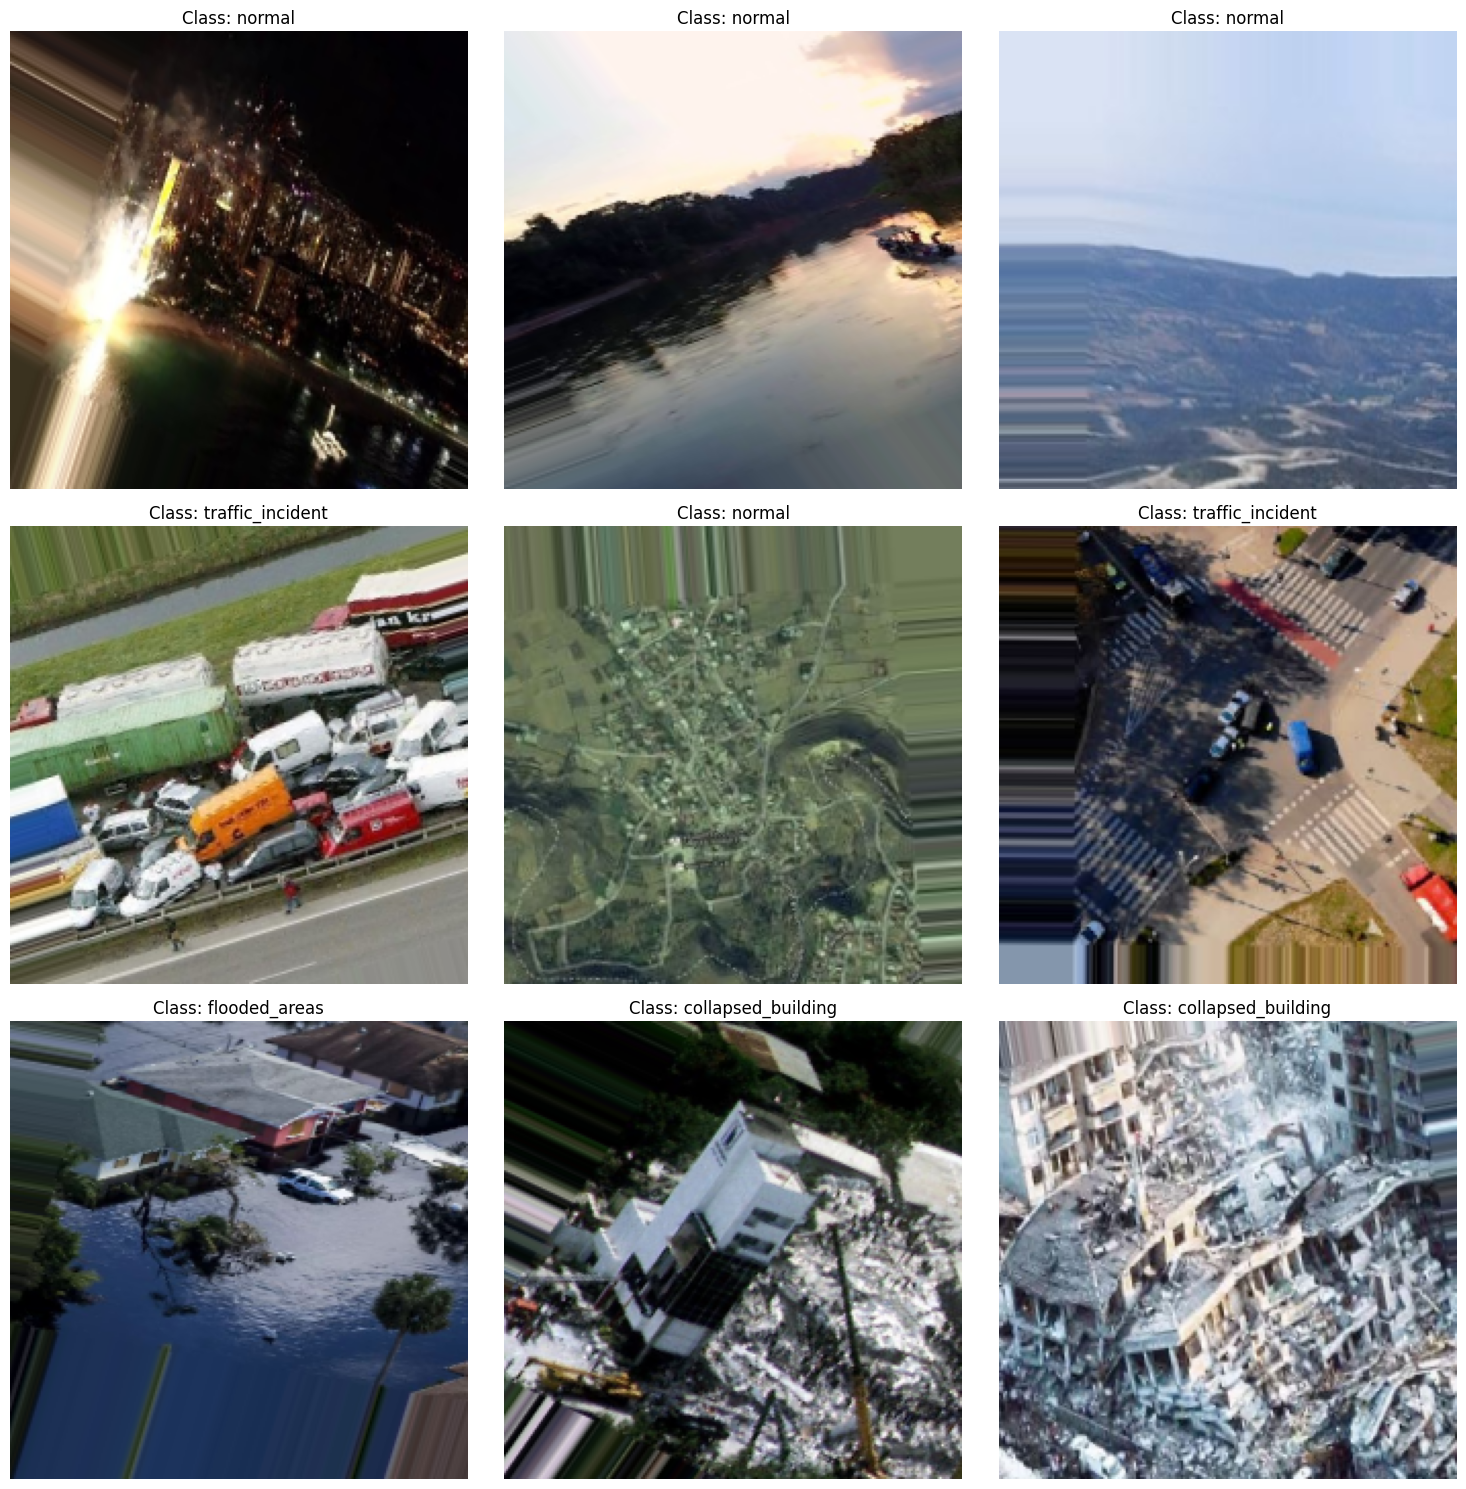

In [ ]:
# Visualisasi sample images
def plot_sample_images(generator, n=9):
    plt.figure(figsize=(15, 15))

    # Get one batch
    images, labels = next(generator)

    for i in range(min(n, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        class_idx = np.argmax(labels[i])
        plt.title(f"Class: {class_names[class_idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Sample training images with augmentation:")
plot_sample_images(train_generator)

## Build MobileNet Model

In [ ]:
def create_mobilenet_model(num_classes):
    """
    Create MobileNet model with transfer learning
    """
    # Load pre-trained MobileNet (tanpa top layer)
    base_model = MobileNet(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model layers
    base_model.trainable = False

    # Build complete model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create model
model = create_mobilenet_model(num_classes)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

# Model summary
model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,886,277 (14.82 MB)

 Trainable params: 657,413 (2.51 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

## Callbacks Setup

In [ ]:
# Custom callback untuk early stopping saat accuracy > 96%
class AccuracyThresholdCallback(keras.callbacks.Callback):
    def __init__(self, threshold=0.96):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')

        if accuracy is not None and accuracy >= self.threshold:
            print(f"\n🎉 Reached {accuracy*100:.2f}% accuracy! Stopping training.")
            self.model.stop_training = True

# Setup callbacks
callbacks = [
    # Custom accuracy threshold callback
    AccuracyThresholdCallback(threshold=ACCURACY_THRESHOLD),

    # Model checkpoint - save best model
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),

    # Reduce learning rate when plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # Standard early stopping (backup)
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

print("Callbacks configured!")

✅ Callbacks configured!


## Training Model

In [ ]:
# Train model
print(" Starting training...\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n Training completed!")

🔥 Starting training...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.7266 - loss: 0.8646 - top_3_accuracy: 0.9294
Epoch 1: val_accuracy improved from -inf to 0.88877, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 137s 790ms/step - accuracy: 0.7271 - loss: 0.8629 - top_3_accuracy: 0.9297 - val_accuracy: 0.8888 - val_loss: 0.3363 - val_top_3_accuracy: 0.9834 - learning_rate: 0.0010
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.8797 - loss: 0.3487 - top_3_accuracy: 0.9866
Epoch 2: val_accuracy improved from 0.88877 to 0.91684, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 132s 774ms/step - accuracy: 0.8797 - loss: 0.3486 - top_3_accuracy: 0.9866 - val_accuracy: 0.9168 - val_loss: 0.2620 - val_top_3_accuracy: 0.9854 - learning_rate: 0.0010
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9063 - loss: 0.2821 - top_3_accuracy: 0.9948
Epoch 3: val_accuracy improved from 0.91684 to 0.93139, saving model to best_model.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 133s 781ms/step - accuracy: 0.9063 - loss: 0.2822 - top_3_accuracy: 0.9948 - val_accuracy: 0.9314 - val_loss: 0.2365 - val_top_3_accuracy: 0.9938 - learning_rate: 0.0010
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.9075 - loss: 0.2691 - top_3_accuracy: 0.9949
Epoch 4: val_accuracy did not improve from 0.93139
171/171 ━━━━━━━━━━━━━━━━━━━━ 133s 775ms/step - accuracy: 0.9075 - loss: 0.2691 - top_3_accuracy: 0.9949 - val_accuracy: 0.9179 - val_loss: 0.2606 - val_top_3_accuracy: 0.9917 - learning_rate: 0.0010
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9135 - loss: 0.2451 - top_3_accuracy: 0.9953
Epoch 5: val_accuracy did not improve from 0.93139
171/171 ━━━━━━━━━━━━━━━━━━━━ 133s 777ms/step - accuracy: 0.9134 - loss: 0.2452 - top_3_accuracy: 0.9953 - val_accuracy: 0.9075 - val_loss: 0.2575 - val_top_3_accuracy: 0.9948 - learning_rate: 0.0010
Epoch 6/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9151

171/171 ━━━━━━━━━━━━━━━━━━━━ 131s 765ms/step - accuracy: 0.9151 - loss: 0.2381 - top_3_accuracy: 0.9954 - val_accuracy: 0.9356 - val_loss: 0.2432 - val_top_3_accuracy: 0.9927 - learning_rate: 0.0010
Epoch 7/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.9268 - loss: 0.2184 - top_3_accuracy: 0.9969
Epoch 7: val_accuracy did not improve from 0.93555
171/171 ━━━━━━━━━━━━━━━━━━━━ 133s 776ms/step - accuracy: 0.9268 - loss: 0.2185 - top_3_accuracy: 0.9969 - val_accuracy: 0.9127 - val_loss: 0.2580 - val_top_3_accuracy: 0.9938 - learning_rate: 0.0010
Epoch 8/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9229 - loss: 0.2105 - top_3_accuracy: 0.9954
Epoch 8: val_accuracy did not improve from 0.93555
171/171 ━━━━━━━━━━━━━━━━━━━━ 136s 793ms/step - accuracy: 0.9229 - loss: 0.2105 - top_3_accuracy: 0.9954 - val_accuracy: 0.9262 - val_loss: 0.2356 - val_top_3_accuracy: 0.9958 - learning_rate: 0.0010
Epoch 9/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.9302

171/171 ━━━━━━━━━━━━━━━━━━━━ 132s 771ms/step - accuracy: 0.9541 - loss: 0.1251 - top_3_accuracy: 0.9981 - val_accuracy: 0.9387 - val_loss: 0.2376 - val_top_3_accuracy: 0.9938 - learning_rate: 5.0000e-04
Epoch 23/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.9596 - loss: 0.1180 - top_3_accuracy: 0.9983
Epoch 23: val_accuracy did not improve from 0.93867
171/171 ━━━━━━━━━━━━━━━━━━━━ 134s 782ms/step - accuracy: 0.9596 - loss: 0.1180 - top_3_accuracy: 0.9983 - val_accuracy: 0.9127 - val_loss: 0.2787 - val_top_3_accuracy: 0.9958 - learning_rate: 5.0000e-04
Epoch 24/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.9621 - loss: 0.1068 - top_3_accuracy: 0.9986
Epoch 24: val_accuracy did not improve from 0.93867
171/171 ━━━━━━━━━━━━━━━━━━━━ 133s 781ms/step - accuracy: 0.9620 - loss: 0.1069 - top_3_accuracy: 0.9986 - val_accuracy: 0.9262 - val_loss: 0.2571 - val_top_3_accuracy: 0.9896 - learning_rate: 5.0000e-04
Epoch 25/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step -

## Visualize Training History

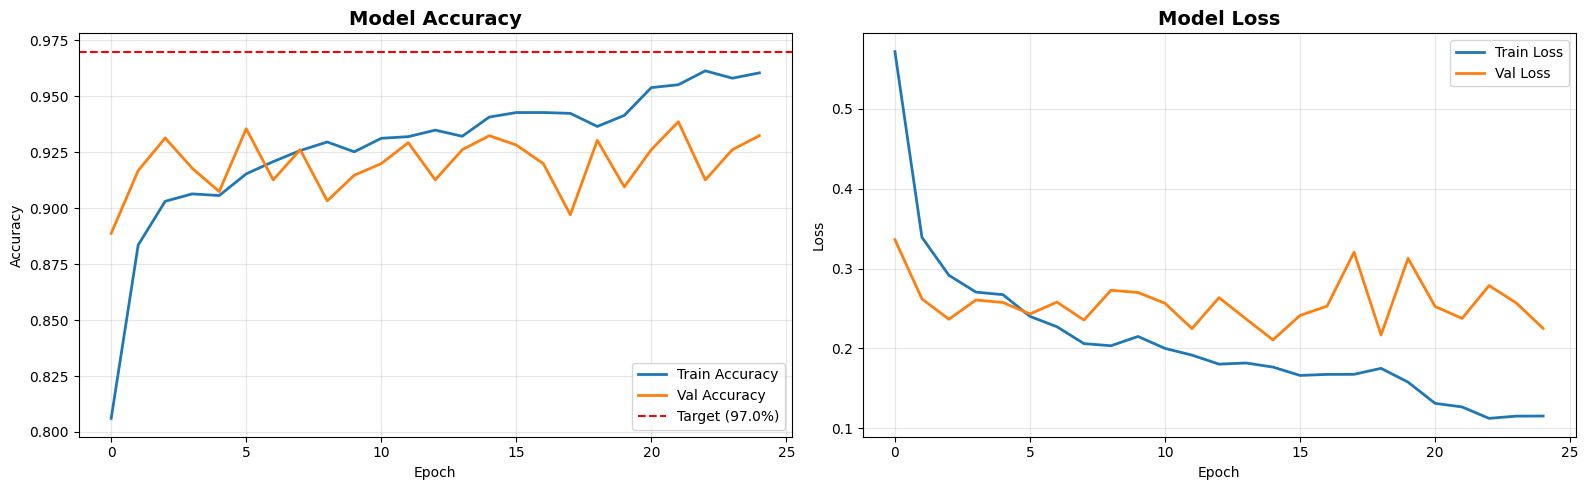

In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].axhline(y=ACCURACY_THRESHOLD, color='r', linestyle='--', label=f'Target ({ACCURACY_THRESHOLD*100}%)')
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(history)

##  Model Evaluation

In [ ]:
# Load best saved model
best_model = keras.models.load_model('best_model.h5')
print("Best model loaded!")

✅ Best model loaded!


In [ ]:
# Evaluate on validation set
print("\nEvaluating on validation set...\n")
val_loss, val_accuracy, val_top3 = best_model.evaluate(val_generator, verbose=1)

print(f"\n{'='*50}")
print(f" VALIDATION METRICS")
print(f"{'='*50}")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy*100:.2f}%")
print(f"Top-3 Accuracy: {val_top3*100:.2f}%")
print(f"{'='*50}\n")


📊 Evaluating on validation set...

31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 631ms/step - accuracy: 0.8547 - loss: 0.5297 - top_3_accuracy: 0.9860

📈 VALIDATION METRICS
Loss: 0.2591
Accuracy: 92.31%
Top-3 Accuracy: 99.48%



In [ ]:
# Get predictions for confusion matrix
print("Generating predictions...")
val_generator.reset()
predictions = best_model.predict(val_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

print(" Predictions generated!")

Generating predictions...
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 648ms/step
✅ Predictions generated!


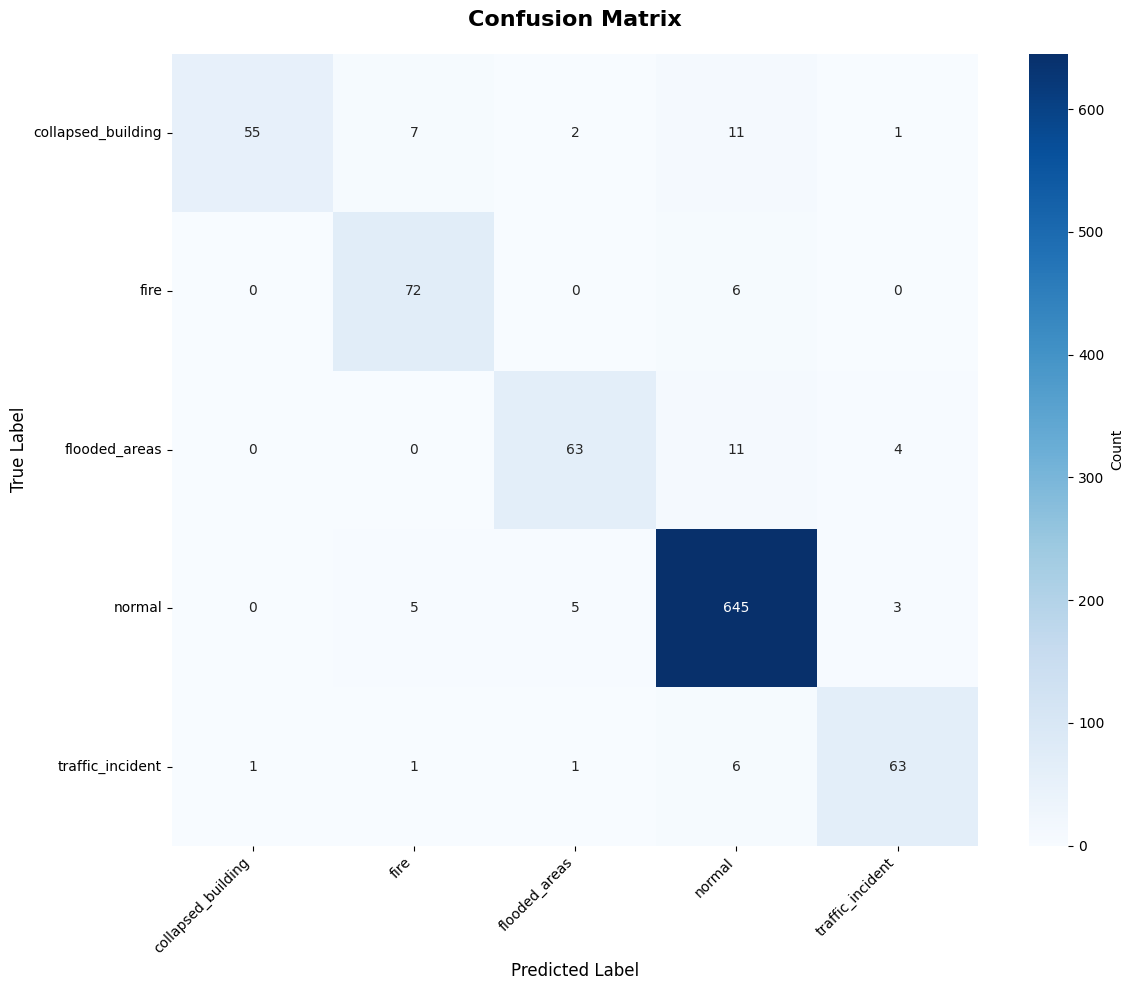

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Classification Report
print("\n CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("="*70)


📋 CLASSIFICATION REPORT
                    precision    recall  f1-score   support

collapsed_building     0.9821    0.7237    0.8333        76
              fire     0.8471    0.9231    0.8834        78
     flooded_areas     0.8873    0.8077    0.8456        78
            normal     0.9499    0.9802    0.9648       658
  traffic_incident     0.8873    0.8750    0.8811        72

          accuracy                         0.9335       962
         macro avg     0.9108    0.8619    0.8817       962
      weighted avg     0.9344    0.9335    0.9319       962



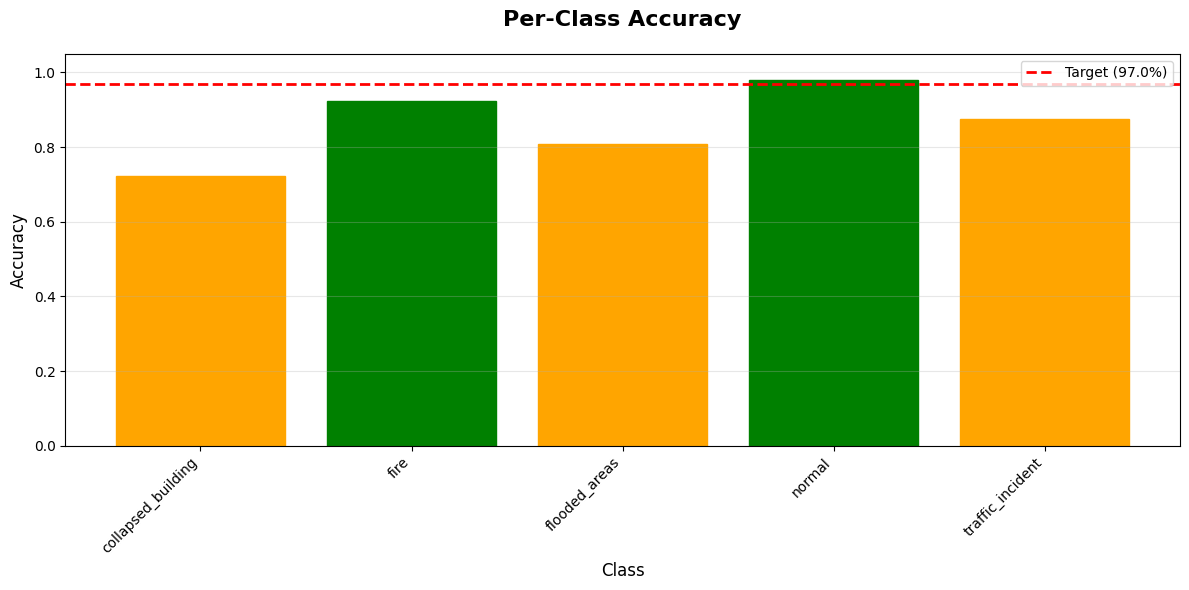


📊 Per-Class Accuracy:
----------------------------------------
collapsed_building  :  72.37%
fire                :  92.31%
flooded_areas       :  80.77%
normal              :  98.02%
traffic_incident    :  87.50%
----------------------------------------


In [ ]:
# Per-class accuracy visualization
from sklearn.metrics import accuracy_score

per_class_acc = []
for i in range(num_classes):
    mask = y_true == i
    if mask.sum() > 0:
        acc = accuracy_score(y_true[mask], y_pred[mask])
        per_class_acc.append(acc)
    else:
        per_class_acc.append(0)

plt.figure(figsize=(12, 6))
bars = plt.bar(range(num_classes), per_class_acc, color='skyblue', edgecolor='navy')

# Color bars based on accuracy
for i, bar in enumerate(bars):
    if per_class_acc[i] >= 0.9:
        bar.set_color('green')
    elif per_class_acc[i] >= 0.7:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.axhline(y=ACCURACY_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Target ({ACCURACY_THRESHOLD*100}%)')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold', pad=20)
plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
plt.ylim([0, 1.05])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Print per-class accuracy
print("\n Per-Class Accuracy:")
print("-" * 40)
for i, class_name in enumerate(class_names):
    print(f"{class_name:20s}: {per_class_acc[i]*100:6.2f}%")
print("-" * 40)

## Sample Predictions Visualization

Sample predictions from validation set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


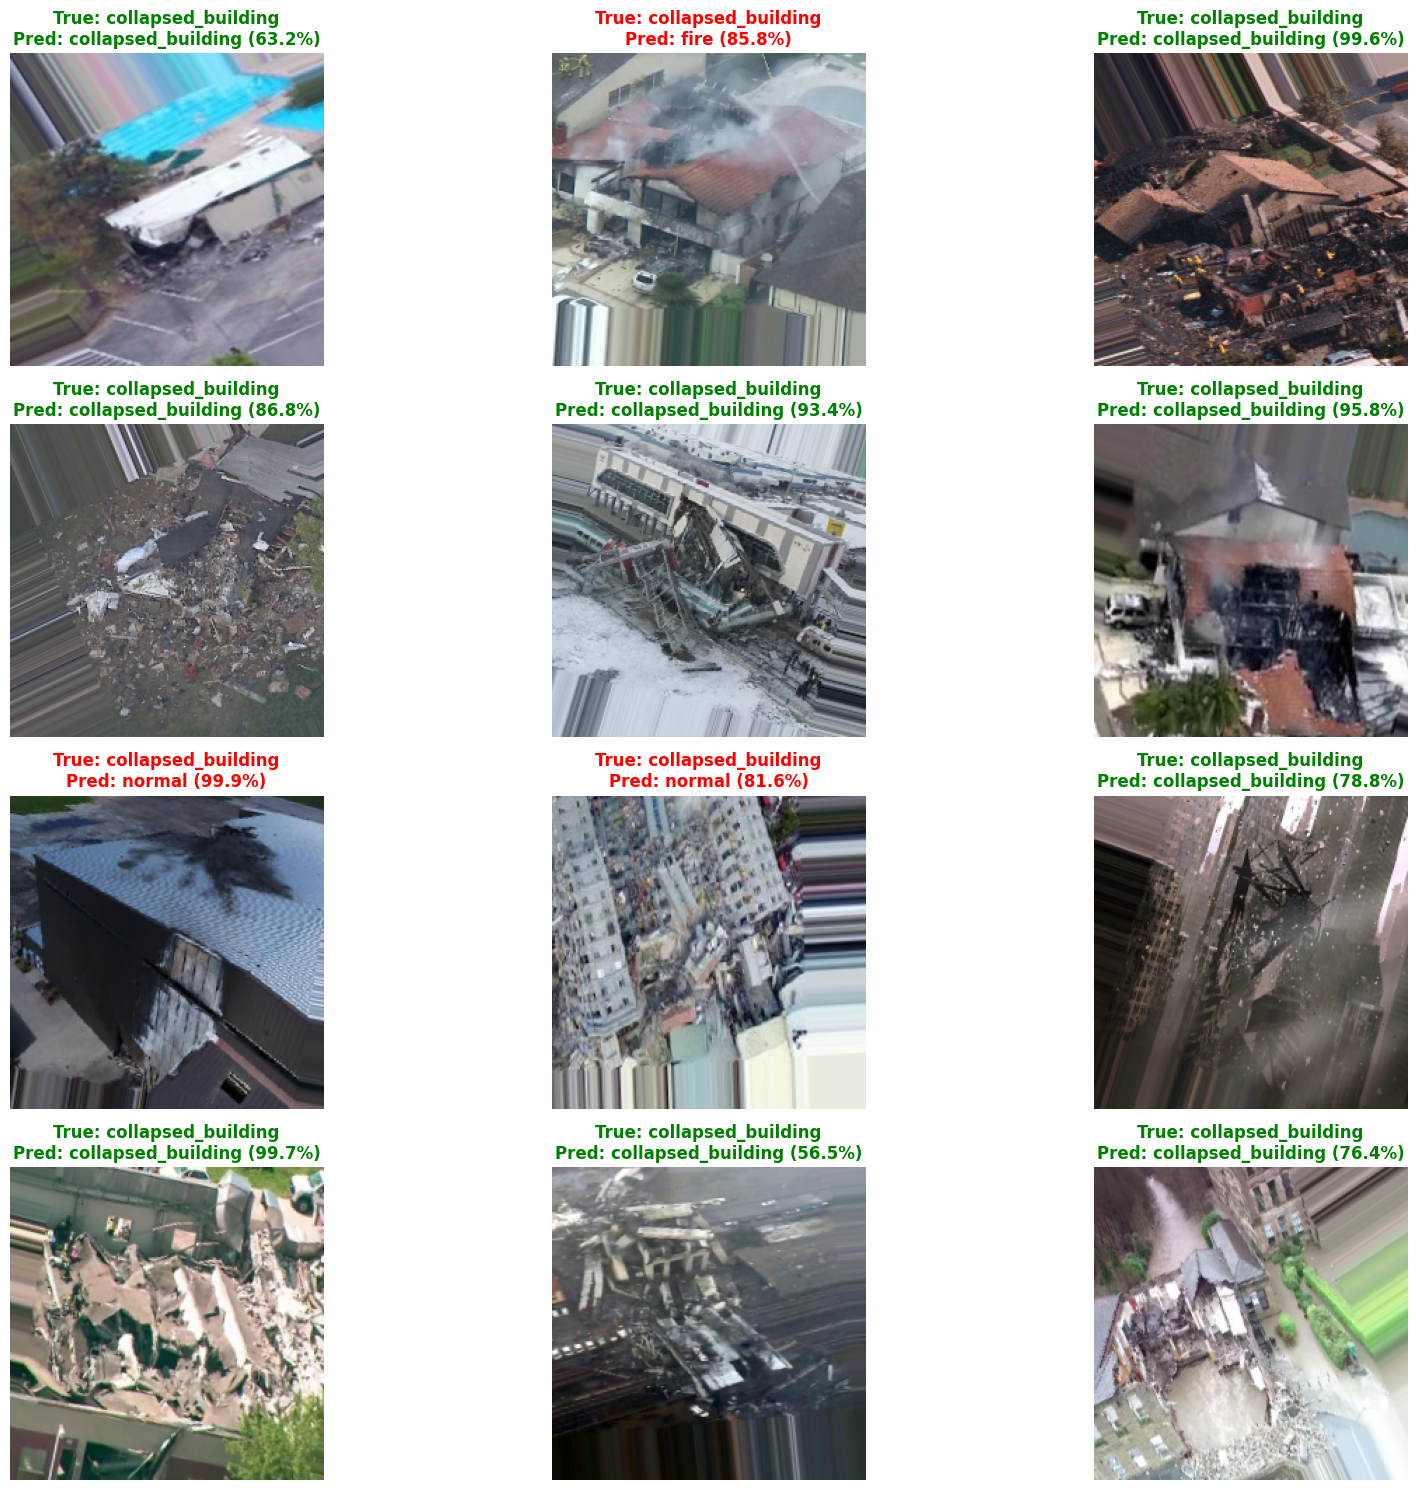

In [ ]:
def plot_predictions(generator, model, num_images=12):
    """
    Plot sample predictions with true and predicted labels
    """
    generator.reset()
    images, labels = next(generator)
    predictions = model.predict(images[:num_images])

    plt.figure(figsize=(18, 15))

    for i in range(min(num_images, len(images))):
        plt.subplot(4, 3, i + 1)
        plt.imshow(images[i])

        true_label = class_names[np.argmax(labels[i])]
        pred_label = class_names[np.argmax(predictions[i])]
        confidence = np.max(predictions[i]) * 100

        # Color: green if correct, red if wrong
        color = 'green' if true_label == pred_label else 'red'

        plt.title(
            f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)",
            color=color,
            fontweight='bold'
        )
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Sample predictions from validation set:")
plot_predictions(val_generator, best_model, num_images=12)

## Save Models

In [ ]:
# Save model dalam format .h5
best_model.save('mobilenet_final_model.h5')
print(" Model saved as mobilenet_final_model.h5")

# Save dalam format SavedModel (TensorFlow)
best_model.export('saved_model')
print(" Model saved in SavedModel format")

✅ Model saved as mobilenet_final_model.h5
Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135903015594192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902996124240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902996123664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135903002708496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902996120208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902996126928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902996124048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902996123856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902996125776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135902996122512: TensorSpec(shape=(), dtype=tf

## Export to TensorFlow.js

In [ ]:
# Convert model to TensorFlow.js format
print("Converting model to TensorFlow.js format...")

tfjs.converters.save_keras_model(best_model, 'tfjs_model')

print("\n Model successfully exported to TensorFlow.js!")
print(" Output directory: tfjs_model/")
print("\nFiles generated:")
!ls -lh tfjs_model/

Converting model to TensorFlow.js format...
failed to lookup keras version from the file,
    this is likely a weight only file

✅ Model successfully exported to TensorFlow.js!
📁 Output directory: tfjs_model/

Files generated:
total 15M
-rw-r--r-- 1 root root 4.0M Jan 27 17:34 group1-shard1of4.bin
-rw-r--r-- 1 root root 4.0M Jan 27 17:34 group1-shard2of4.bin
-rw-r--r-- 1 root root 4.0M Jan 27 17:34 group1-shard3of4.bin
-rw-r--r-- 1 root root 2.9M Jan 27 17:34 group1-shard4of4.bin
-rw-r--r-- 1 root root  85K Jan 27 17:34 model.json


In [ ]:
# Save class names for TensorFlow.js
import json

class_info = {
    'class_names': class_names,
    'num_classes': num_classes,
    'image_size': list(IMG_SIZE)
}

with open('tfjs_model/class_names.json', 'w') as f:
    json.dump(class_info, f, indent=2)

print(" Class names saved to tfjs_model/class_names.json")
print("\nClass info:")
print(json.dumps(class_info, indent=2))

✅ Class names saved to tfjs_model/class_names.json

Class info:
{
  "class_names": [
    "collapsed_building",
    "fire",
    "flooded_areas",
    "normal",
    "traffic_incident"
  ],
  "num_classes": 5,
  "image_size": [
    224,
    224
  ]
}


## Download Models & Results

In [ ]:
# Compress files untuk download
!zip -r models_and_results.zip \
    best_model.h5 \
    mobilenet_final_model.h5 \
    tfjs_model/ \
    training_history.png \
    confusion_matrix.png \
    per_class_accuracy.png \
    sample_predictions.png

print("\n Files compressed successfully!")
print("\n Ready to download: models_and_results.zip")

  adding: best_model.h5 (deflated 7%)
  adding: mobilenet_final_model.h5 (deflated 8%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard4of4.bin (deflated 7%)
  adding: tfjs_model/class_names.json (deflated 34%)
  adding: tfjs_model/group1-shard3of4.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of4.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 96%)
  adding: tfjs_model/group1-shard2of4.bin (deflated 7%)
  adding: training_history.png (deflated 13%)
  adding: confusion_matrix.png (deflated 28%)
  adding: per_class_accuracy.png (deflated 27%)
  adding: sample_predictions.png (deflated 7%)

✅ Files compressed successfully!

📦 Ready to download: models_and_results.zip


In [ ]:
# Download compressed file
from google.colab import files

print("Downloading models_and_results.zip...")
files.download('models_and_results.zip')
print("\n Download complete!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download complete!


##  Training Summary

In [ ]:
print("\n" + "="*70)
print(" TRAINING SUMMARY")
print("="*70)
print(f"\n Dataset:")
print(f"  • Total classes: {num_classes}")
print(f"  • Training samples: {train_generator.samples}")
print(f"  • Validation samples: {val_generator.samples}")
print(f"  • Classes: {', '.join(class_names)}")

print(f"\n Model Architecture:")
print(f"  • Base: MobileNet (ImageNet pretrained)")
print(f"  • Input size: {IMG_SIZE}")
print(f"  • Total parameters: {best_model.count_params():,}")

print(f"\n Training Configuration:")
print(f"  • Batch size: {BATCH_SIZE}")
print(f"  • Initial learning rate: {LEARNING_RATE}")
print(f"  • Epochs trained: {len(history.history['loss'])}")
print(f"  • Data augmentation:  Enabled")
print(f"  • Early stopping threshold: {ACCURACY_THRESHOLD*100}%")

print(f"\n Final Results:")
print(f"  • Validation Loss: {val_loss:.4f}")
print(f"  • Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"  • Top-3 Accuracy: {val_top3*100:.2f}%")

if val_accuracy >= ACCURACY_THRESHOLD:
    print(f"\n   SUCCESS! Achieved target accuracy of {ACCURACY_THRESHOLD*100}%")
else:
    print(f"\n   Target accuracy ({ACCURACY_THRESHOLD*100}%) not reached")

print(f"\n Saved Files:")
print(f"  • best_model.h5")
print(f"  • mobilenet_final_model.h5")
print(f"  • tfjs_model/ (TensorFlow.js format)")
print(f"  • Training visualizations (PNG files)")

print("\n" + "="*70)
print(" PROJECT COMPLETED SUCCESSFULLY!")
print("="*70 + "\n")


🎯 TRAINING SUMMARY

📊 Dataset:
  • Total classes: 5
  • Training samples: 5471
  • Validation samples: 962
  • Classes: collapsed_building, fire, flooded_areas, normal, traffic_incident

🏗️ Model Architecture:
  • Base: MobileNet (ImageNet pretrained)
  • Input size: (224, 224)
  • Total parameters: 3,886,277

📈 Training Configuration:
  • Batch size: 32
  • Initial learning rate: 0.001
  • Epochs trained: 25
  • Data augmentation: ✅ Enabled
  • Early stopping threshold: 97.0%

🎯 Final Results:
  • Validation Loss: 0.2591
  • Validation Accuracy: 92.31%
  • Top-3 Accuracy: 99.48%

  ⚠️ Target accuracy (97.0%) not reached

💾 Saved Files:
  • best_model.h5
  • mobilenet_final_model.h5
  • tfjs_model/ (TensorFlow.js format)
  • Training visualizations (PNG files)

✅ PROJECT COMPLETED SUCCESSFULLY!



## Deploy with Gradio


In [ ]:
!pip install -q gradio

In [ ]:
import gradio as gr
from PIL import Image
import pandas as pd
from datetime import datetime

In [ ]:
def predict_image(image_input):
    # Preprocess the input image
    img = image_input.resize(IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    img_array = img_array / 255.0 # Rescale to 0-1

    # Make prediction
    predictions = best_model.predict(img_array)
    scores = tf.nn.softmax(predictions[0])

    # Format output for Gradio
    output_dict = {class_names[i]: float(scores[i]) for i in range(num_classes)}

    # Get top predicted class
    top_label = max(output_dict, key=output_dict.get)
    top_confidence = output_dict[top_label]

    # Get description for the top label
    # `incident_descriptions` is assumed to be a global dictionary defined in the Gradio interface cell.
    description = incident_descriptions.get(top_label, "Deskripsi tidak tersedia.")

    return output_dict, f"**Prediksi Tertinggi:** {top_label} ({top_confidence:.2%})\n\n**Deskripsi:** {description}"

print("✅ Prediction function created!")

In [ ]:
# Variabel global
history_data = []

incident_descriptions = {
    'collapsed_building': 'Telah terdeteksi bangunan roboh, kemungkinan disebabkan oleh gempa bumi atau ledakan.',
    'fire': 'Kebakaran terdeteksi. Segera laporkan agar tim pemadam kebakaran dapat bertindak cepat.',
    'flooded_areas': 'Area terdeteksi banjir. Informasikan ketinggian air dan cakupan area yang terdampak.',
    'normal': 'Area ini terlihat normal dan aman. Tidak ada insiden yang terdeteksi.',
    'traffic_incident': 'Terjadi insiden lalu lintas. Laporkan jenis kejadian dan dampaknya.'
}

# Fungsi untuk prediksi saja (tanpa simpan riwayat)
def predict_only(img):
    """Prediksi otomatis saat gambar diupload"""
    if img is None:
        return {}, "Silakan upload gambar terlebih dahulu."

    try:
        output_dict, formatted_description = predict_image(img)
        return output_dict, formatted_description
    except NameError:
        return {"normal": 0.9}, "Model belum dimuat."

# Fungsi untuk laporan (prediksi + simpan riwayat + clear)
def predict_with_metadata(img, location):
    """Prediksi, simpan riwayat, dan clear gambar"""
    if img is None:
        return {}, pd.DataFrame(history_data, columns=["Waktu", "Insiden", "Lokasi"]), None, "Tidak ada gambar untuk dilaporkan."

    try:
        output_dict, formatted_description = predict_image(img)
        result = {k: float(v) for k, v in output_dict.items()}
    except NameError:
        result = {"normal": 0.9}
        formatted_description = "Prediksi tidak tersedia."

    top_label = max(result, key=result.get)
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Simpan ke riwayat
    history_data.append([now, top_label, location if location else "-"])
    history_df = pd.DataFrame(history_data, columns=["Waktu", "Insiden", "Lokasi"])

    # Return: hasil, riwayat, None (clear gambar), deskripsi
    return output_dict, history_df, None, formatted_description

# Inisialisasi
try:
    if 'best_model' not in globals():
        best_model = tf.keras.models.load_model('mobilenet_final_model.h5')
    class_names = ['collapsed_building', 'fire', 'flooded_areas', 'normal', 'traffic_incident']
    num_classes = len(class_names)
except:
    num_classes = 5
    class_names = ['collapsed_building', 'fire', 'flooded_areas', 'normal', 'traffic_incident']

# Interface Gradio
with gr.Blocks(theme=gr.themes.Soft(primary_hue="red")) as demo:
    gr.Markdown("# 🚨 Dashboard BantuDarurat AI")
    gr.Markdown("Upload gambar untuk prediksi otomatis. Klik **LAPORKAN INSIDEN** untuk menyimpan ke riwayat.")

    with gr.Tabs():
        with gr.TabItem("📸 Analisis Real-time"):
            with gr.Row():
                with gr.Column():
                    input_img = gr.Image(
                        sources=["upload", "webcam"],
                        type="pil",
                        label="Upload atau Ambil Foto"
                    )
                    input_loc = gr.Textbox(
                        label="Lokasi (Opsional)",
                        placeholder="Contoh: Medan, Sumut"
                    )

                    # TOMBOL CLEAR DIHAPUS ❌
                    btn_report = gr.Button("📋 LAPORKAN INSIDEN", variant="primary")

                with gr.Column():
                    output_label = gr.Label(num_top_classes=num_classes, label="Hasil Prediksi")
                    output_description = gr.Markdown("_Upload gambar untuk melihat prediksi_")

        with gr.TabItem("📜 Riwayat Laporan"):
            gr.Markdown("### Daftar Insiden yang Dilaporkan")
            output_history = gr.Dataframe(
                headers=["Waktu", "Insiden", "Lokasi"],
                datatype=["str", "str", "str"],
                interactive=False
            )

    # EVENT 1: Prediksi OTOMATIS saat gambar berubah (upload/webcam)
    input_img.change(
        fn=predict_only,
        inputs=input_img,
        outputs=[output_label, output_description],
        show_progress="hidden"  # Tidak tampilkan loading bar untuk UX lebih halus
    )

    # EVENT 2: Simpan ke riwayat + clear gambar saat tombol diklik
    btn_report.click(
        fn=predict_with_metadata,
        inputs=[input_img, input_loc],
        outputs=[output_label, output_history, input_img, output_description]
    )

demo.launch(share=True)

## Create file requirement.txt


In [ ]:
import pkg_resources

def generate_requirements_file(filename='requirements.txt'):
    """
    Generates a requirements.txt file with the packages used in this notebook.
    """
    # List of packages identified as used in the notebook
    # This list can be manually curated or dynamically generated
    used_packages = [
        'tensorflow',
        'keras',
        'numpy',
        'matplotlib',
        'seaborn',
        'google-colab',
        'tensorflow-hub',
        'kagglehub',
        'scikit-learn',
        'tensorflowjs',
        'gradio',
        'Pillow',
        'pandas'
    ]

    # Get all installed packages and their versions
    installed_packages = {pkg.key: pkg.version for pkg in pkg_resources.working_set}

    # Filter for used packages and write to file
    with open(filename, 'w') as f:
        for package_name in used_packages:
            normalized_name = package_name.lower().replace('_', '-')
            if normalized_name in installed_packages:
                f.write(f"{package_name}=={installed_packages[normalized_name]}\n")
            else:
                print(f"Warning: Package '{package_name}' not found in installed packages. Skipping.")

    print(f" {filename} created successfully with identified dependencies!")
    print("You may need to manually verify and add any missing implicit dependencies.")

# Run the function to generate the requirements.txt file
generate_requirements_file()
